In [1]:
%matplotlib notebook

import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

import time
import logging

logging.basicConfig(level=logging.INFO)

import sys
sys.path.append('./convex_models')

from cvx_optim import CVXRegressor
from cvx_utils import make_features, kernel_func
from lin_cvx_reg import fit_affine_convex, predict_affine_convex


### Utilities

In [2]:
def fun(X, flatness=2):
    return (np.cos(flatness * np.linalg.norm(X, axis=1)) - 1) / flatness**2 + .5 * np.linalg.norm(X, axis=1) ** 2

def sample_data(n, dim, scale, noise, flatness):
    # Sample convex data + noise
    X = 2 * scale * (np.random.rand(n, dim) - .5 * np.ones(dim))
    Y = fun(X.squeeze(), flatness) + noise * np.random.randn(n)
    return X, Y

## Generate some data

In [3]:
np.random.seed(1111)

n = 15
dim = 2

noise = .2
scale = 2
flatness = 1 #lower the flatter

X, Y = sample_data(n, dim, scale, noise, flatness)

<IPython.core.display.Javascript object>


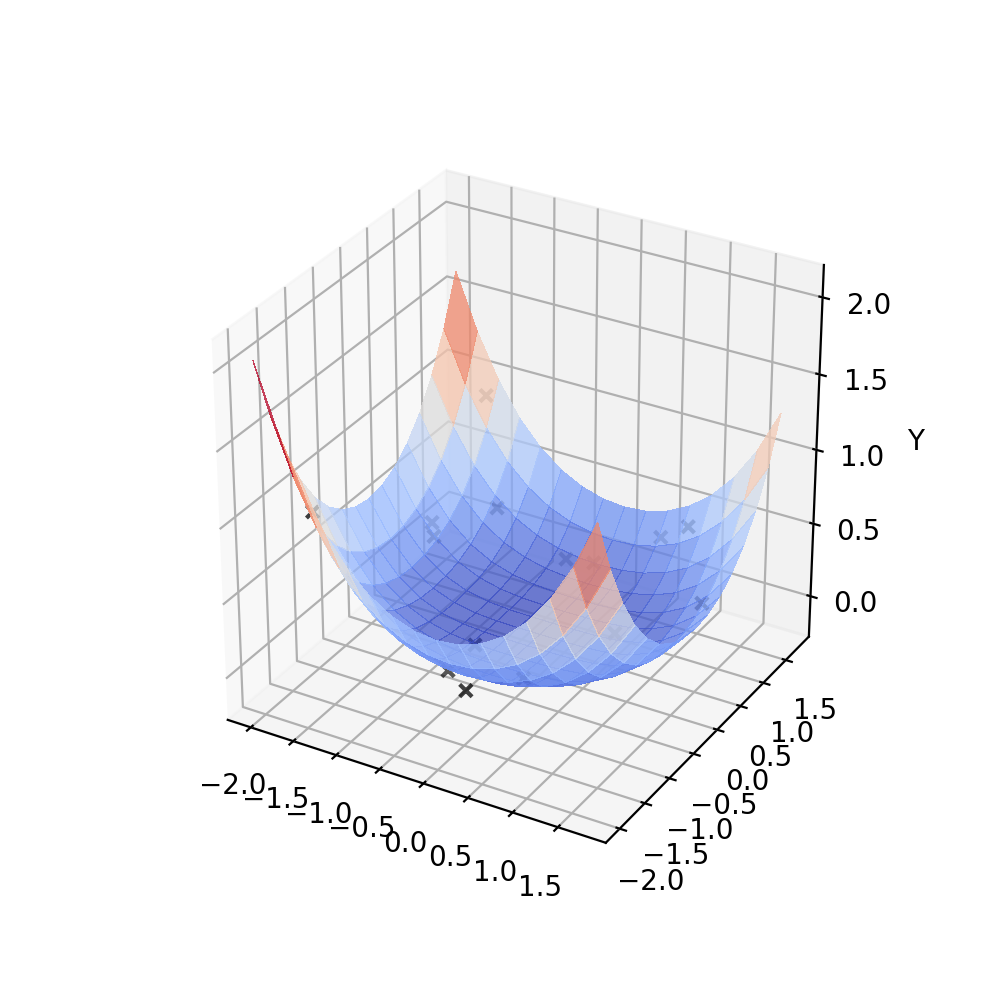

In [4]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')


ax.scatter(X[:, 0], X[:, 1], Y, marker='x', color='black')
ax.set_zlabel('Y')


# Make data.
xx = np.arange(-scale, scale, 0.25)
yy = np.arange(-scale, scale, 0.25)
xx, yy = np.meshgrid(xx, yy)
Z = fun(np.vstack((xx.flatten(), yy.flatten())).T, flatness).reshape(xx.shape)

# Plot the surface.
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, linewidth=0, 
                       antialiased=False, alpha=.75)

plt.show()

## Run Optimization

In [5]:
# Model parameters

bw = 10
rho = 1e-3
lbda_1 = 0
lbda_2 = 1e-6
sampling = 'sobol'
n_fill = 20
nystrom = True
r = 20


# Optimization hyperparameters

max_iter = 500000
precision = 1e-6
eps=1e-12
report_interval = 10000


In [6]:
cvx_reg = CVXRegressor(bw=bw, rho=rho, lbda_1=lbda_1, lbda_2=lbda_2, 
                       max_iter=max_iter, precision=precision, eps=eps,
                       nystrom=nystrom, r=r, sampling=sampling, n_fill=n_fill)    

cvx_reg.fit(X, Y, verbose=True, report_interval=report_interval)


INFO:root:iter 0:	loss: 1.15e-01	grad norm: 9.39e-02
INFO:root:iter 10000:	loss: 1.14e-01	grad norm: 3.14e-06
INFO:root:iter 13592:	loss: 1.14e-01	grad norm: 1.00e-06
INFO:root:Precision 1.00e-06 reached in 3.69e+00 seconds



## Plot and compare with baselines

### Kernel sums of squares

<IPython.core.display.Javascript object>


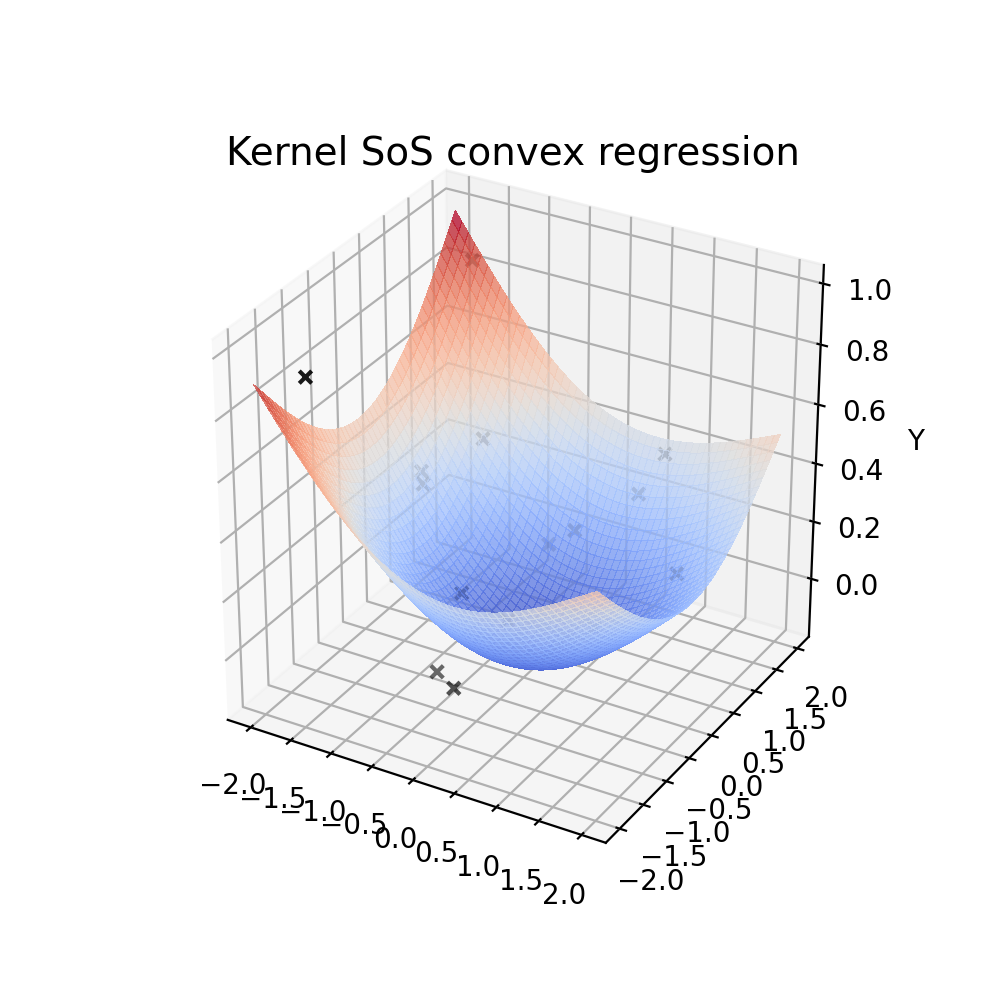

In [7]:
if dim == 2:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')


    ax.scatter(X[:, 0], X[:, 1], Y, marker = 'x', color='black')
    ax.set_zlabel('Y')


    # Make data.
    xx = np.arange(-scale, scale, 0.01)
    yy = np.arange(-scale, scale, 0.01)
    xx, yy = np.meshgrid(xx, yy)

    t = np.vstack((xx.flatten(), yy.flatten())).T
    f = cvx_reg.predict(t).reshape(xx.shape)

    # Plot the surface.
    surf = ax.plot_surface(xx, yy, f, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha=.75)

    plt.title('Kernel SoS convex regression', fontsize=14)
    plt.show()

### Ridge

In [8]:
kr = GridSearchCV(KernelRidge(kernel='rbf'),
                  param_grid={"alpha": np.logspace(-12, 5, 18),
                              "gamma": np.logspace(-9, 9, 19)})

t0 = time.time()
kr.fit(X, Y)
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)



KRR complexity and bandwidth selected and model fitted in 1.634 s


<IPython.core.display.Javascript object>


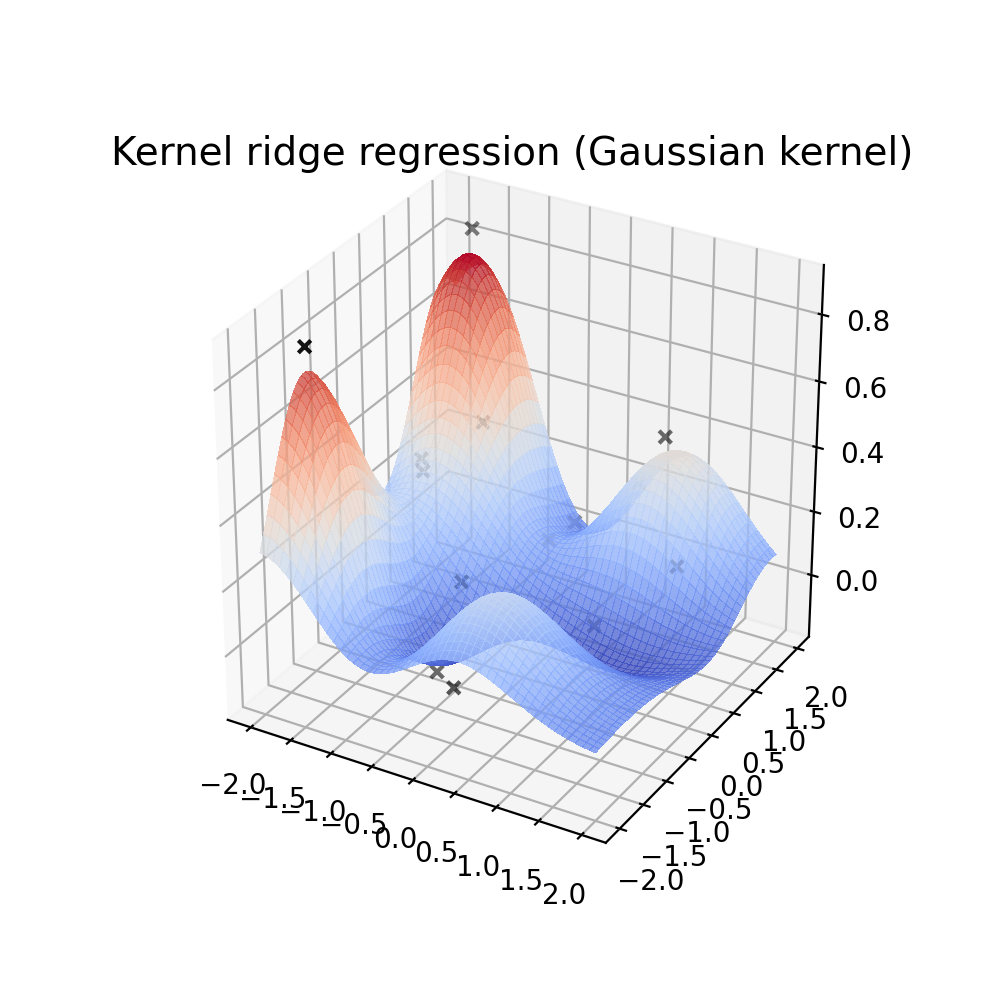

In [9]:
if dim == 2:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(X[:, 0], X[:, 1], Y, marker='x', color='black')
   
    # Make data.
    xx = np.arange(-scale, scale, 0.01)
    yy = np.arange(-scale, scale, 0.01)
    xx, yy = np.meshgrid(xx, yy)

    t = np.vstack((xx.flatten(), yy.flatten())).T
    y_kr = kr.best_estimator_.predict(t)

    # Plot the surface
    surf = ax.plot_surface(xx, yy, y_kr.reshape(xx.shape), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha=.75)



    plt.title("Kernel ridge regression (Gaussian kernel)", fontsize=14)

### Piecewise linear

In [10]:
yhat, g = fit_affine_convex(X, Y)

<IPython.core.display.Javascript object>


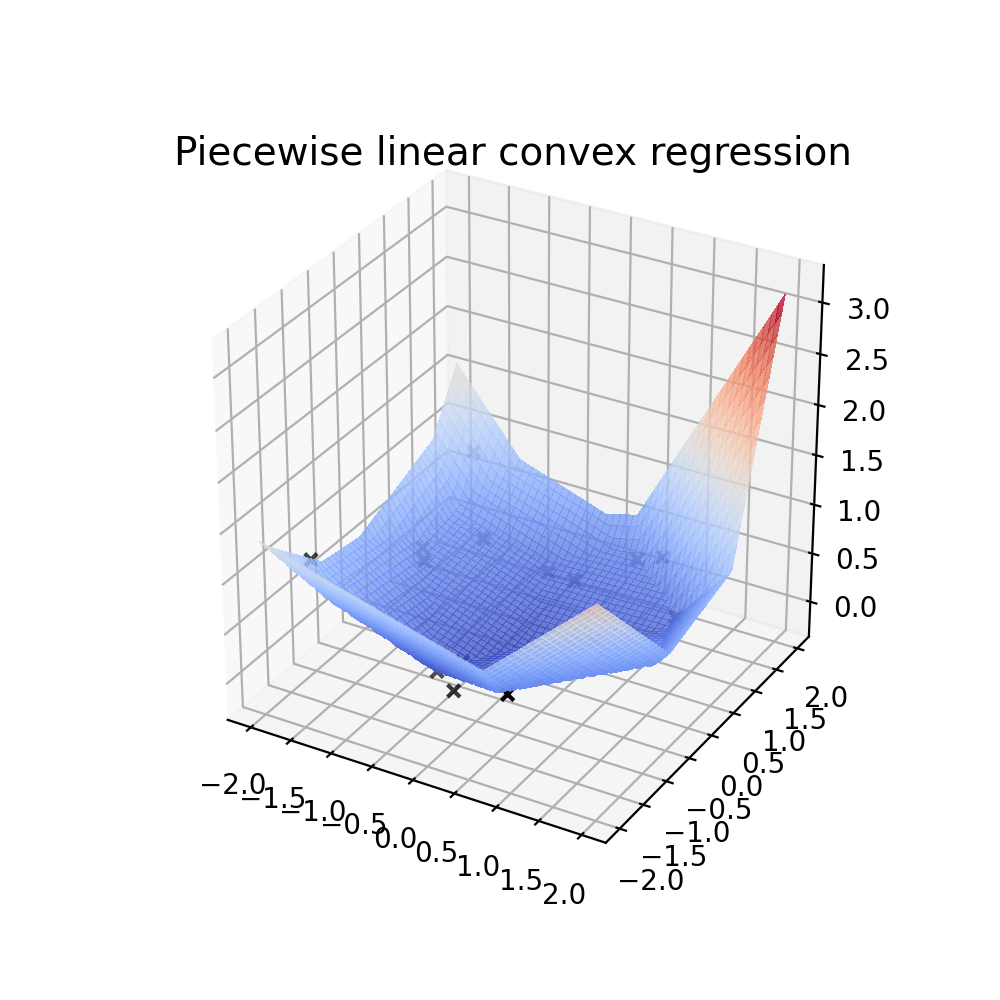

In [11]:
if dim == 2:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(X[:, 0], X[:, 1], Y, marker='x', color='black')
    
    
    # Make data.
    xx = np.arange(-scale, scale, 0.01)
    yy = np.arange(-scale, scale, 0.01)
    xx, yy = np.meshgrid(xx, yy)

    t = np.vstack((xx.flatten(), yy.flatten())).T
    
    f_lin = predict_affine_convex(t, yhat, g, X)

    surf = ax.plot_surface(xx, yy, f_lin.reshape(xx.shape), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha=.75)


    plt.title("Piecewise linear convex regression", fontsize=14)